In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Загрузка и подготовка датасета

In [2]:
df = pd.read_csv('./TZ_GP (2).csv', parse_dates=['client_time'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396099 entries, 0 to 396098
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        396099 non-null  object        
 1   media_source   396099 non-null  object        
 2   client_time    396099 non-null  datetime64[ns]
 3   session_index  396099 non-null  int64         
 4   game_status    396099 non-null  object        
 5   event_name     396099 non-null  object        
 6   event_data     396099 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 21.2+ MB


In [4]:
df.isna().sum()

user_id          0
media_source     0
client_time      0
session_index    0
game_status      0
event_name       0
event_data       0
dtype: int64

In [5]:
df.head()

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
0,60c588d7b4d1b24b40531f29,organic,2021-06-05 07:23:06,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""Xiaomi POCO M2 Pro"",""graphicMemory""..."
1,60d34c7ab4d1b24b405324ac,organic,2021-06-05 16:33:26,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-J200G"",""graphicMemory"":2..."
2,60babef87c80da6a9442cb86,ad-traffic,2021-06-05 00:02:07,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-G781B"",""graphicMemory"":2..."
3,60bac0e912667e6a8d107731,ad-traffic,2021-06-05 00:04:29,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-T290"",""graphicMemory"":51..."
4,60babfb17c80da6a9442cb87,organic,2021-06-05 00:05:16,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-N960F"",""graphicMemory"":2..."


In [6]:
# парсим колонки с json-структурой в отдельные датафреймы и объединяем с основным датафреймы
gst = pd.json_normalize(df.game_status.apply(json.loads))

In [7]:
# поскольку присутствуют поля с одинаковыми названиями, изменим названия колонок
gst.rename(columns={'coins':'game_coins', 'level':'game_level'}, inplace=True)

In [8]:
events = pd.json_normalize(df.event_data.apply(json.loads))

In [9]:
df = pd.concat([df, gst, events], axis=1)

In [10]:
# оставляем только колонки с релевантной информацией (согласно описанию в ТЗ)
new_cols = ['user_id', 'media_source', 'client_time', 'session_index', 'event_name',
            'game_coins', 'freeRounds', 'freeUndo', 'freeWildCard', 'freeAddCards',
            'gladeId', 'game_level', 'bet', 'device', 'graphicMemory', 'systemMemory',
            'name', 'level', 'amount', 'from', 'levels', 'type', 'time', 'levelLoop',
            'win', 'stars', 'cardsOnField', 'cardsOnHands', 'price', 'cardsInHand',
            'inLevel', 'productDescription', 'usdProceed'
           ]

In [11]:
df = df[new_cols]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396099 entries, 0 to 396098
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   user_id             396099 non-null  object        
 1   media_source        396099 non-null  object        
 2   client_time         396099 non-null  datetime64[ns]
 3   session_index       396099 non-null  int64         
 4   event_name          396099 non-null  object        
 5   game_coins          396099 non-null  int64         
 6   freeRounds          396099 non-null  int64         
 7   freeUndo            396099 non-null  int64         
 8   freeWildCard        396099 non-null  int64         
 9   freeAddCards        396099 non-null  int64         
 10  gladeId             395946 non-null  float64       
 11  game_level          396099 non-null  int64         
 12  bet                 395946 non-null  float64       
 13  device              452 non-n

## Первый взгляд на данные, информация об игроках

Text(0.5, 1, 'Распределение событий игры')

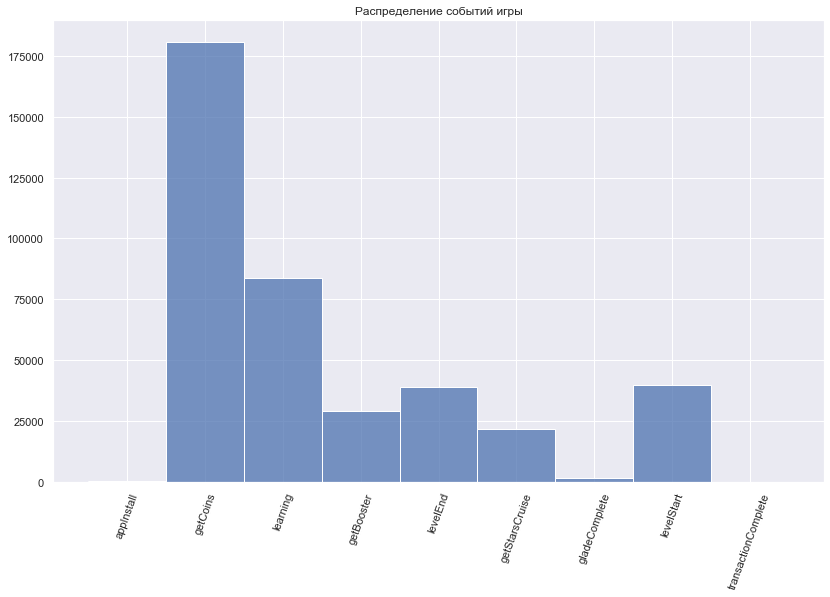

In [13]:
sns.histplot(data=df.event_name).set(xlabel=None, ylabel=None)
plt.xticks(rotation=70)
plt.tight_layout()
plt.title('Распределение событий игры')

In [14]:
df.user_id.nunique()

452

In [15]:
media = df.drop_duplicates(subset='user_id').groupby('media_source', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'users'})

Text(0.5, 1.0, 'Распределение игроков по источнику установки')

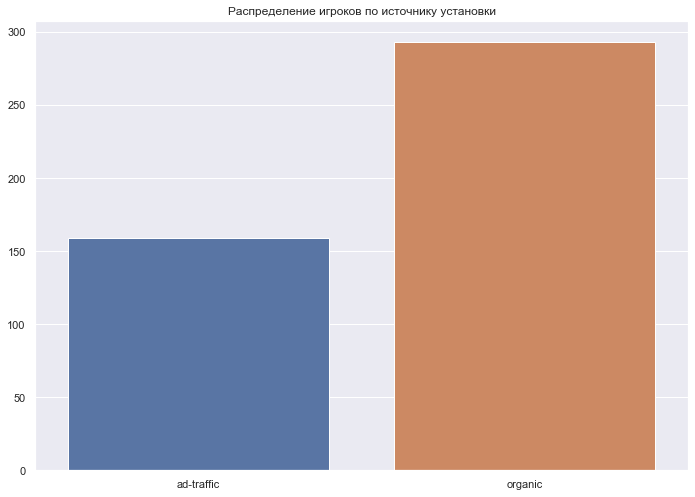

In [16]:
sns.barplot(x='media_source', y='users', data=media).set(xlabel=None, ylabel=None)
plt.title('Распределение игроков по источнику установки')

In [17]:
df.device = df.device.str.split(' ').str[0]

In [18]:
df.device.value_counts().head(10)

samsung     197
HUAWEI       66
Xiaomi       49
OPPO         26
motorola     16
vivo         13
LGE          10
realme        9
LENOVO        6
TCL           6
Name: device, dtype: int64

In [19]:
top_devices = (
    df.drop_duplicates(subset='user_id')
    .groupby('device', as_index=False).user_id.count().sort_values(by='user_id', ascending=False).head(10)
)

Text(0.5, 1, 'Топ девайсов игроков')

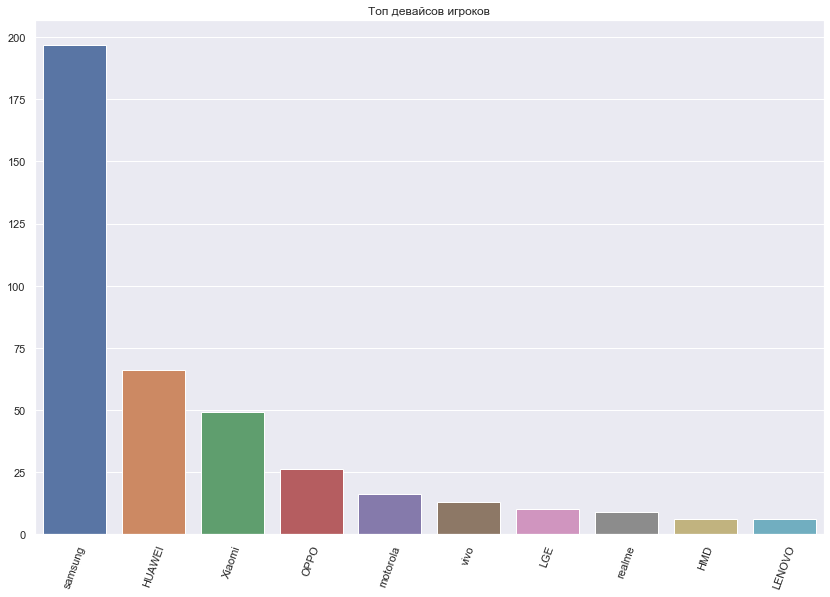

In [20]:
sns.barplot(data=top_devices, x='device', y='user_id').set(xlabel=None, ylabel=None)
plt.xticks(rotation=70)
plt.tight_layout()
plt.title('Топ девайсов игроков')

In [21]:
df.graphicMemory.mean()

1043.5398230088495

In [22]:
df.systemMemory.mean()

3249.1106194690265

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Размер графической памяти девайсов')]

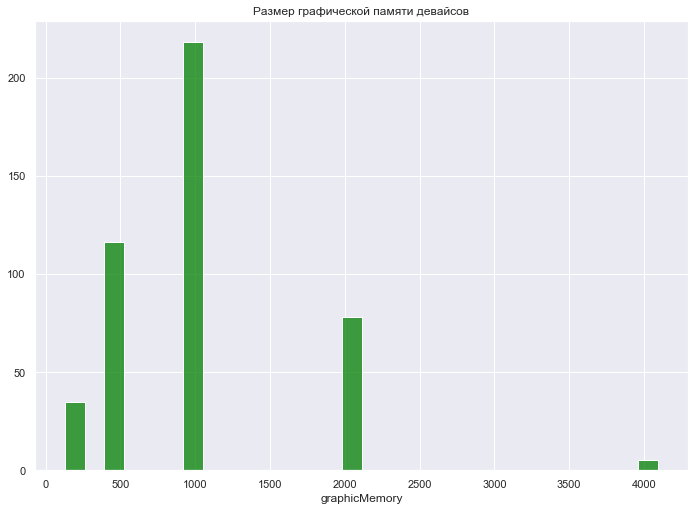

In [23]:
sns.histplot(df.drop_duplicates(subset='user_id').graphicMemory, color='green').set(ylabel=None, title='Размер графической памяти девайсов')

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Размер системной памяти девайсов')]

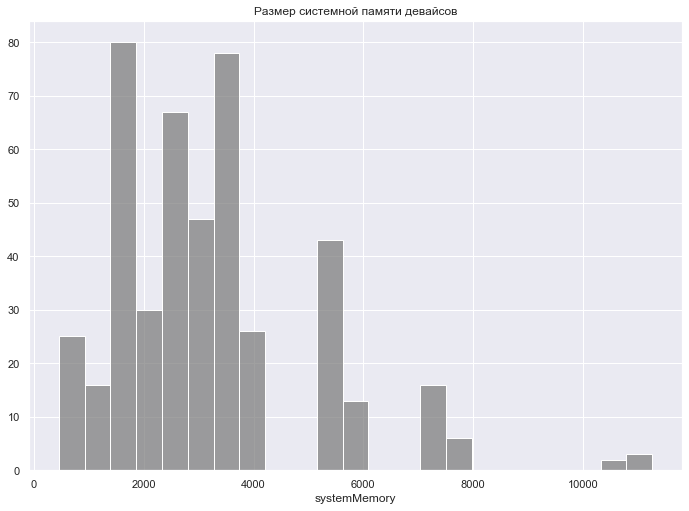

In [24]:
sns.histplot(df.drop_duplicates(subset='user_id').systemMemory, color='gray').set(ylabel=None, title='Размер системной памяти девайсов')

In [25]:
user_sessions = df.groupby('user_id', as_index=False).session_index.count()

In [26]:
user_sessions.session_index.mean()

876.3252212389381

Text(0.5, 1.0, 'Количество игровых сессий')

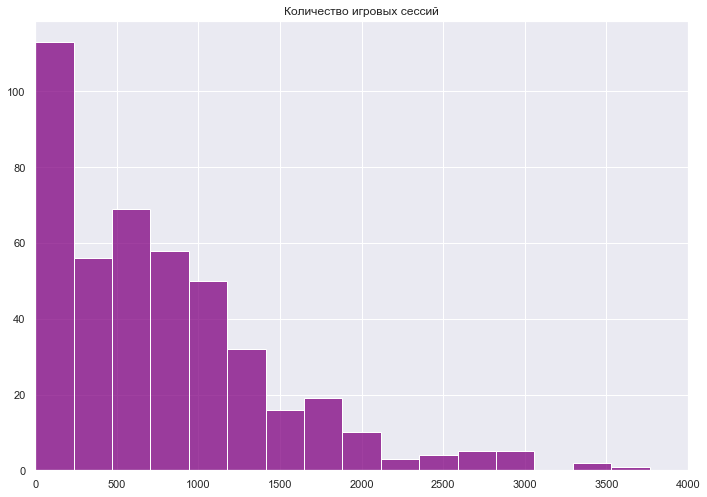

In [27]:
sns.histplot(user_sessions.session_index, color='purple').set(xlabel=None, ylabel=None)
plt.xlim([0, 4000])
plt.title('Количество игровых сессий')

In [28]:
daily_activity = df.groupby(df.client_time.dt.date).agg({'session_index':'count'})

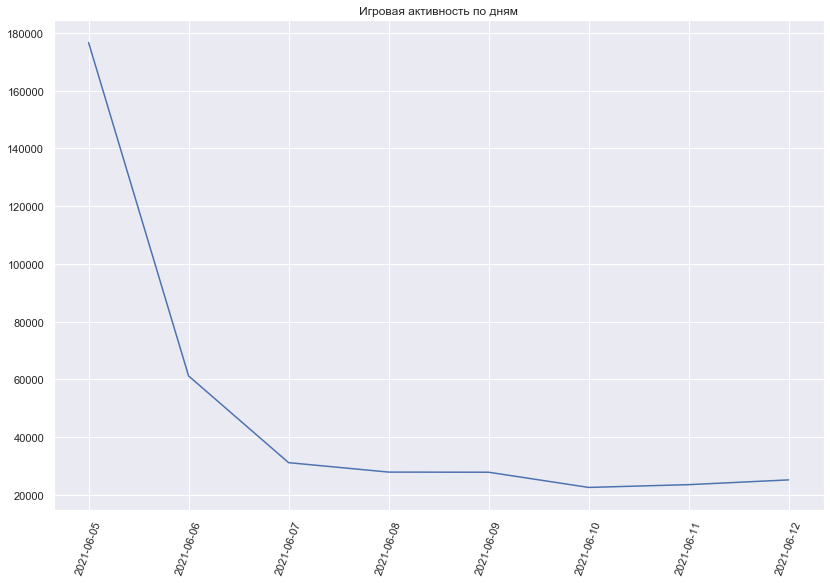

In [29]:
sns.lineplot(x='client_time', y='session_index', data=daily_activity).set(xlabel=None, ylabel=None)
plt.title('Игровая активность по дням')
plt.xticks(rotation=70)
plt.tight_layout()

## 1.1 FTUE

In [30]:
df.query('gladeId == 1').event_name.value_counts()

learning          21723
getCoins           8614
getBooster         3936
levelStart         3392
levelEnd           3282
getStarsCruise     2913
appInstall          451
Name: event_name, dtype: int64

Text(0.5, 1.0, 'Распределение событий при прохождении первой грядки')

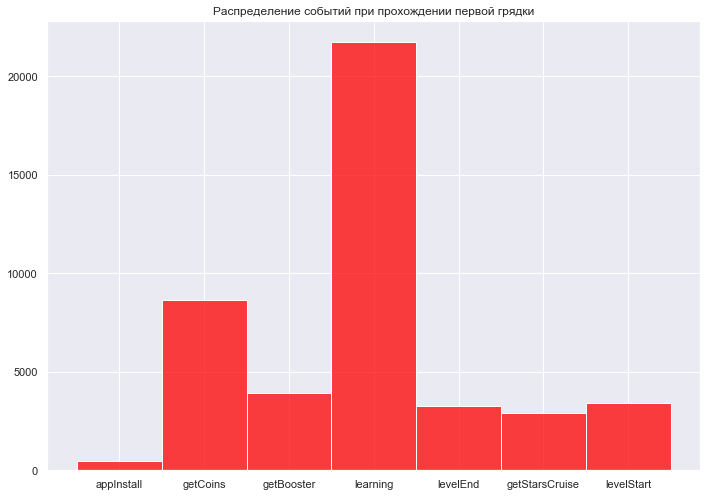

In [31]:
sns.histplot(df.query('gladeId == 1').event_name, color='red').set(xlabel=None, ylabel=None)
plt.title('Распределение событий при прохождении первой грядки')

In [32]:
df.query('event_name == "learning" and gladeId == 1').name.value_counts()

CRUISE_NEXT_CARD                  8999
CRUISE_GET_CARD_FROM_DECK_MORE    8608
DROP_CARDS                         796
CRUISE_DROP_FIRST_CARD             367
CRUISE_SAFE                        344
CRUISE_STREAK                      340
CRUISE_STREAK_STAR                 336
CRUISE_GET_CARD_FROM_DECK          333
CRUISE_WILD_CARD_USING             316
CRUISE_EXTRA_CARDS                 243
CRUISE_UNDO                        234
CRUISE_DOUBLE_STREAK               216
CRUISE_AVAILABLE_WILD_CARD         173
CRUISE_USE_BOOSTERS_MORE           110
MAIN_RULE                           99
GET_CARD                            90
ADD_CARDS                           84
USE_UNDO                            27
CRUISE_USE_BOOSTERS                  8
Name: name, dtype: int64

In [33]:
df.query('gladeId == 1 and event_name == "getCoins" and amount > 0').amount.mean()

1416.98992

In [34]:
df.query('gladeId == 1 and event_name == "getCoins" and amount <= 0').amount.mean()

-982.0219966159052

Text(0.5, 1.0, 'Использование бустеров при прохождении первой грядки')

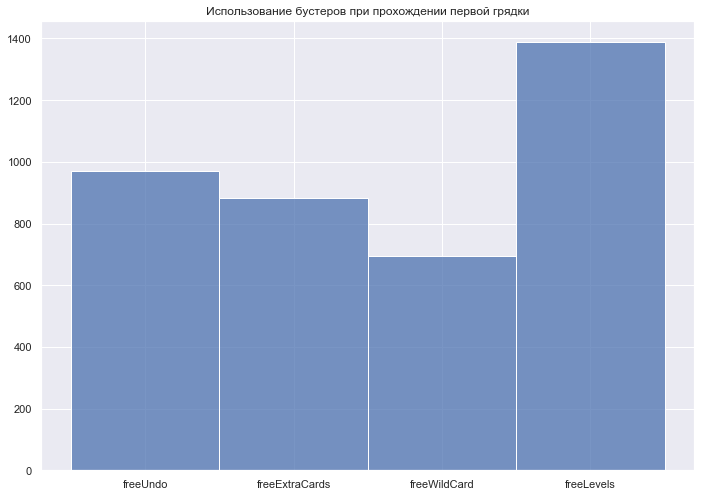

In [35]:
sns.histplot(df.query('gladeId == 1 and event_name == "getBooster"').type).set(xlabel=None, ylabel=None)
plt.title('Использование бустеров при прохождении первой грядки')

In [36]:
df.query('gladeId == 1 and event_name == "levelEnd"').time.mean()

87599.95917123705

Text(0.5, 1.0, 'Распределение выигрышей при прохождении первой грядки')

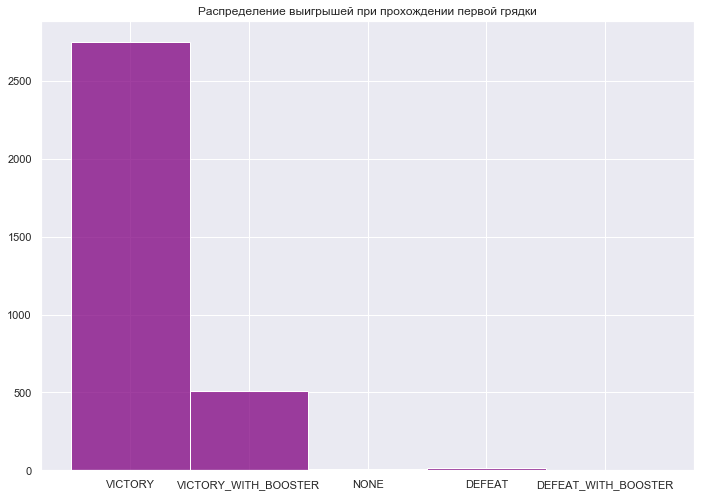

In [37]:
sns.histplot(df.query('gladeId == 1 and event_name == "levelEnd"').win, color='purple').set(xlabel=None, ylabel=None)
plt.title("Распределение выигрышей при прохождении первой грядки")

Text(0.5, 1.0, 'Количество собранных звезд при прохождении первой грядки')

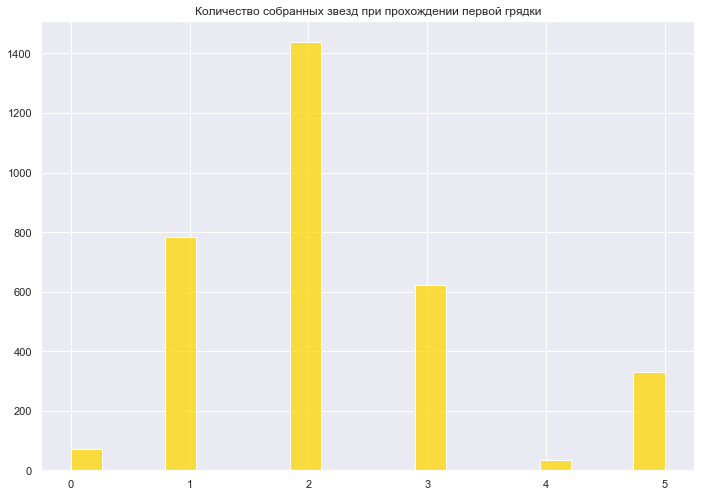

In [38]:
sns.histplot(df.query('gladeId == 1 and event_name == "levelEnd"').stars, color='gold').set(xlabel=None, ylabel=None)
plt.title('Количество собранных звезд при прохождении первой грядки')

## 1.2 Качество контента

In [39]:
# выделим датасет по первым 30 уровням
lvls = list(range(0, 31))

In [40]:
df_first_levels = df[df.levelLoop.isin(lvls)]

In [41]:
level_time = df_first_levels.query('event_name == "levelEnd"').groupby('levelLoop', as_index=False).time.mean()

([<matplotlib.axis.XTick at 0x7fb24cc44490>,
 <a list of 31 Text xticklabel objects>)

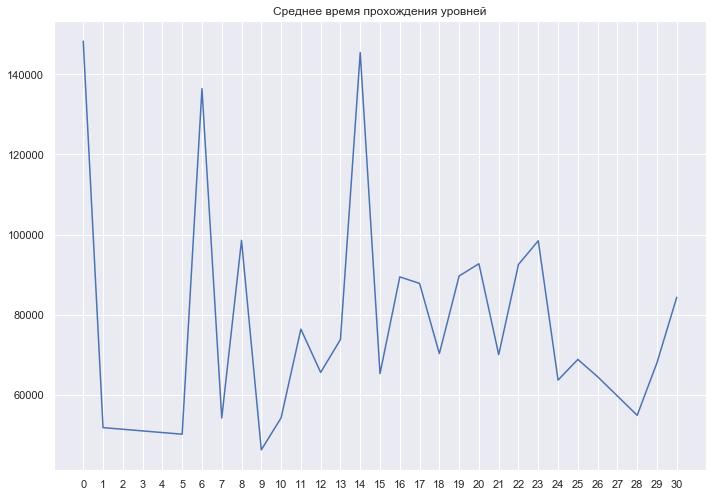

In [42]:
sns.lineplot(x='levelLoop', y='time', data=level_time).set(xlabel=None, ylabel=None)
plt.title('Среднее время прохождения уровней')
plt.xticks(np.arange(0, 31))

Text(0.5, 1.0, 'Распределение исходов уровней')

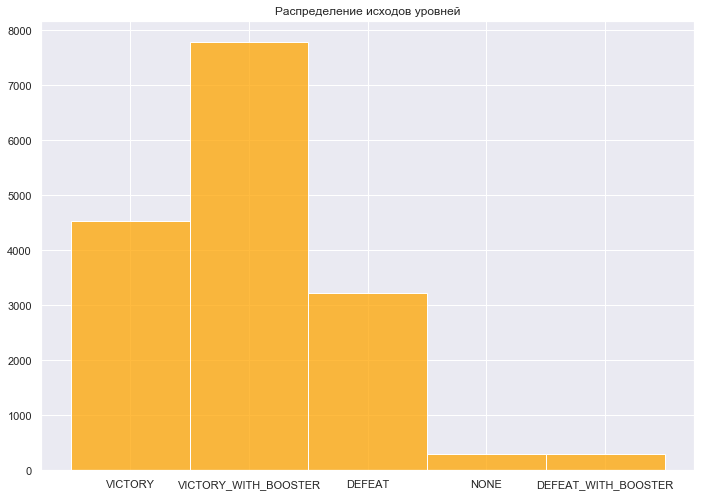

In [43]:
sns.histplot(df_first_levels.query('event_name == "levelEnd"').win, color='orange').set(xlabel=None, ylabel=None)
plt.title('Распределение исходов уровней')

In [44]:
level_stars = df_first_levels.query('event_name == "levelEnd"').groupby('levelLoop', as_index=False).stars.mean()

Text(0.5, 1.0, 'Среднее количество собранных звезд за уровень')

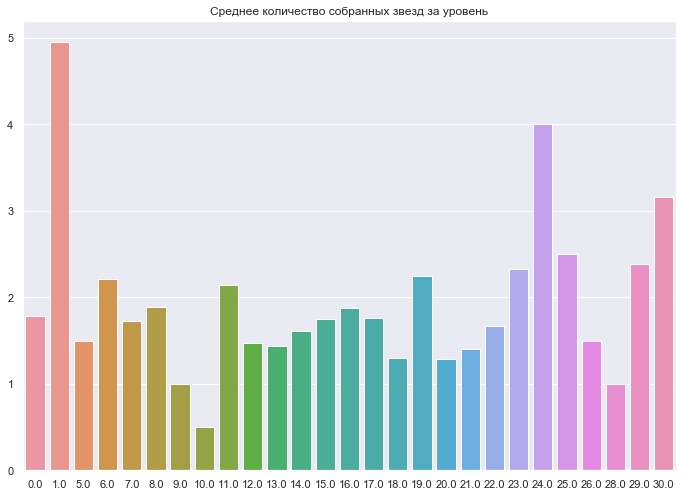

In [45]:
sns.barplot(data=level_stars, x='levelLoop', y='stars').set(xlabel=None, ylabel=None)
plt.title("Среднее количество собранных звезд за уровень")

In [46]:
cards_field = df_first_levels.query('event_name == "levelEnd"').groupby('levelLoop', as_index=False).cardsOnField.mean()

Text(0.5, 1.0, 'Среднее количество карт, оставшихся на поле при поражении')

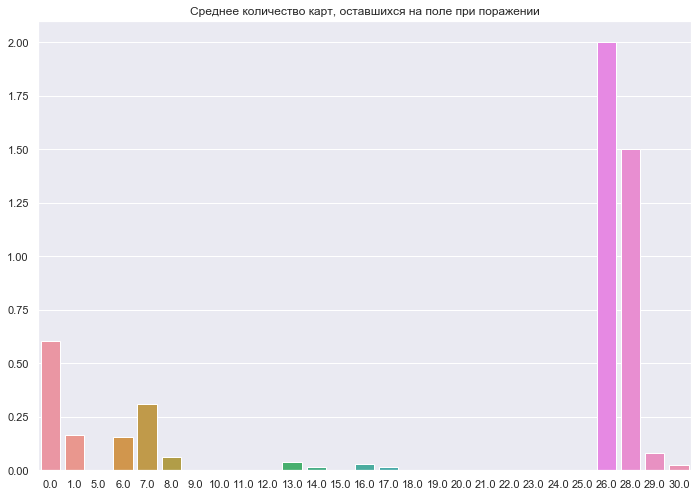

In [47]:
sns.barplot(data=cards_field, x='levelLoop', y='cardsOnField').set(xlabel=None, ylabel=None)
plt.title('Среднее количество карт, оставшихся на поле при поражении')

In [48]:
cards_hand = df_first_levels.query('event_name == "levelEnd"').groupby('levelLoop', as_index=False).cardsOnHands.mean()

Text(0.5, 1.0, 'Среднее количество карт, оставшихся у игрока после победы')

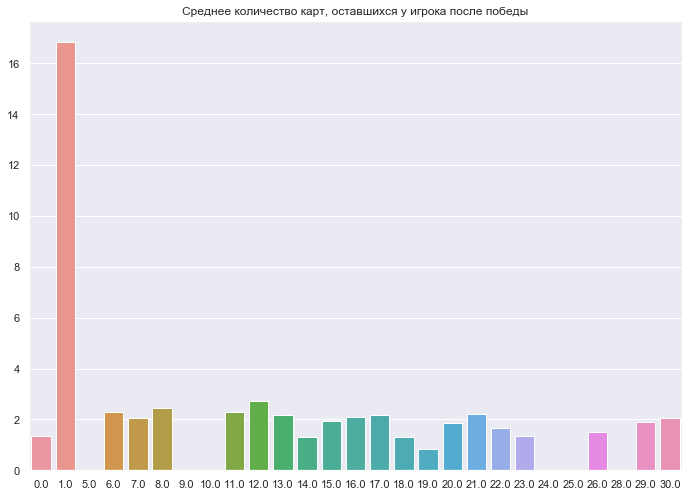

In [49]:
sns.barplot(data=cards_hand, x='levelLoop', y='cardsOnHands').set(xlabel=None, ylabel=None)
plt.title('Среднее количество карт, оставшихся у игрока после победы')

In [50]:
level_price = df_first_levels.query('event_name == "levelStart"').groupby('levelLoop', as_index=False).price.mean()

Text(0.5, 1.0, 'Средняя стоимость начала уровня (в звездах)')

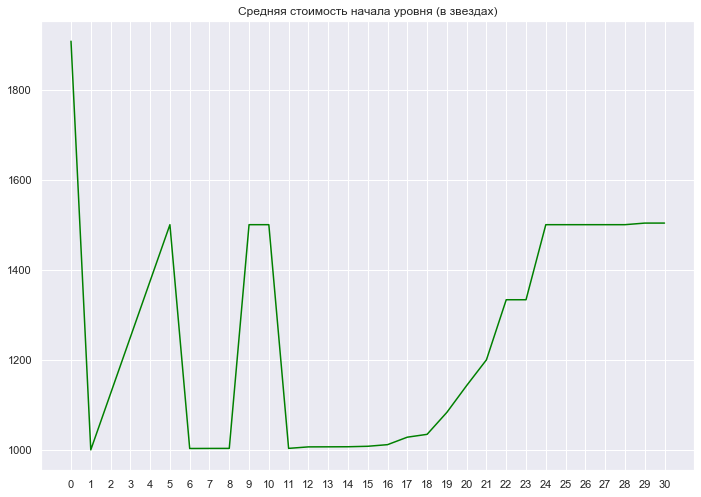

In [51]:
sns.lineplot(data=level_price, x='levelLoop', y='price', color='green').set(xlabel=None, ylabel=None)
plt.xticks(np.arange(0, 31))
plt.title('Средняя стоимость начала уровня (в звездах)')

In [52]:
cards_hand_start = df_first_levels.query('event_name == "levelStart"').groupby('levelLoop', as_index=False).cardsInHand.mean()

Text(0.5, 1.0, 'Средний размер колоды игрока в начале уровня')

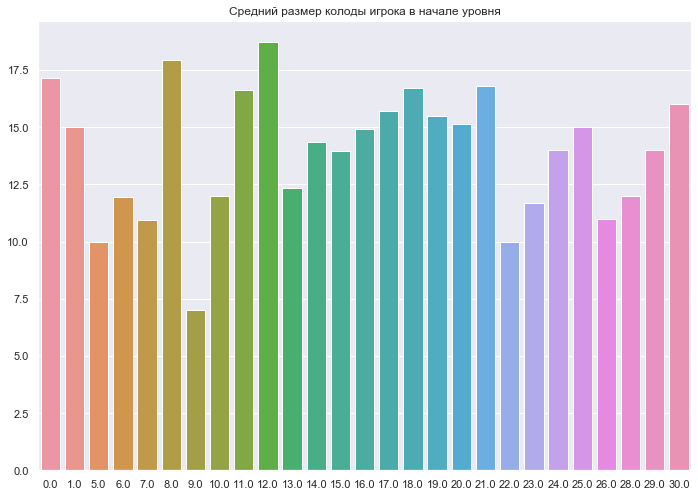

In [53]:
sns.barplot(data=cards_hand_start, x='levelLoop', y='cardsInHand').set(xlabel=None, ylabel=None)
plt.title('Средний размер колоды игрока в начале уровня')

In [54]:
df_first_levels.query('event_name == "transactionComplete"')

,user_id,media_source,client_time,session_index,event_name,game_coins,freeRounds,freeUndo,freeWildCard,freeAddCards,...,levelLoop,win,stars,cardsOnField,cardsOnHands,price,cardsInHand,inLevel,productDescription,usdProceed


## 1.3* Оценка трафика

In [55]:
cpi = 1.8

In [56]:
installs_ad = df.drop_duplicates(subset='user_id').query('media_source == "ad-traffic"').shape[0]

In [57]:
ad_cost = cpi * installs_ad

In [58]:
ad_cost

286.2

In [59]:
ad_profit = df.query('media_source == "ad-traffic"').usdProceed.sum()

In [60]:
ad_profit

56.5762952652839

In [61]:
(ad_profit / ad_cost) * 100

19.768097576968522